In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/train_2017.csv


이 노트북에서는 Zillow 상금 경쟁에서 제공된 데이터를 탐색해보려고 합니다. 데이터에 깊이 파고들기 전에, 경쟁에 대해 좀 더 알아보겠습니다.

Zillow:

Zillow은 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다. - 위키피디아

Zestimate:

“Zestimates”는 각 부동산의 수백 가지 데이터 포인트를 분석하는 750만 개의 통계 및 머신 러닝 모델을 기반으로 한 추정 집 값입니다. 그리고 중간 오차 범위를 계속 개선하여 (시작 시 14%에서 현재는 5%로) 더욱 정확도가 높아졌습니다.

목표:

Zestimate 잔차 오차를 개선하는 모델 구축.

이 경쟁은 두 단계로 이루어져 있습니다. 이 공개 경쟁은 2018년 1월까지 진행되며 상금은 $50,000입니다. 이 경쟁의 상세 내용과 개요를 꼭 읽어보시기 바랍니다.

먼저 필요한 모듈을 가져오겠습니다.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [5]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

zillow-prize-1



In [7]:
train_df = pd.read_csv("/kaggle/input/zillow-prize-1/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [8]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


목표변수: logerror

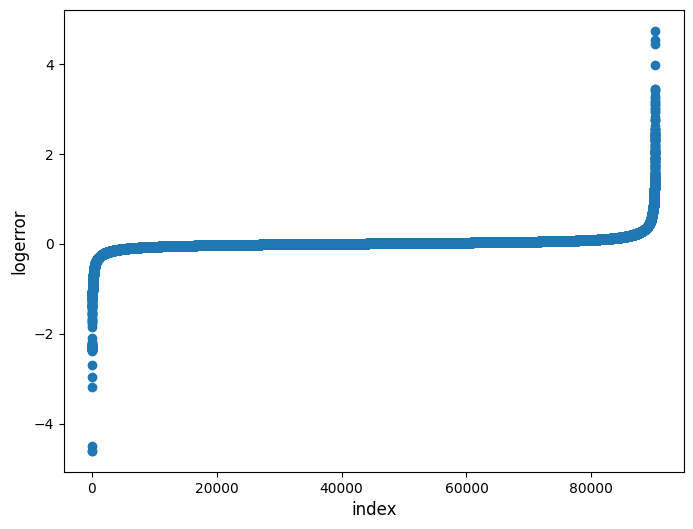

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

이것은 양쪽 끝에 일부 이상치가 있는 괜찮은 모습입니다.!

이상치를 제거한 후 동일한 히스토그램 플롯을 작성해보겠습니다.

/tmp/ipykernel_34/4058255462.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.logerror.values, bins=50, kde=False)


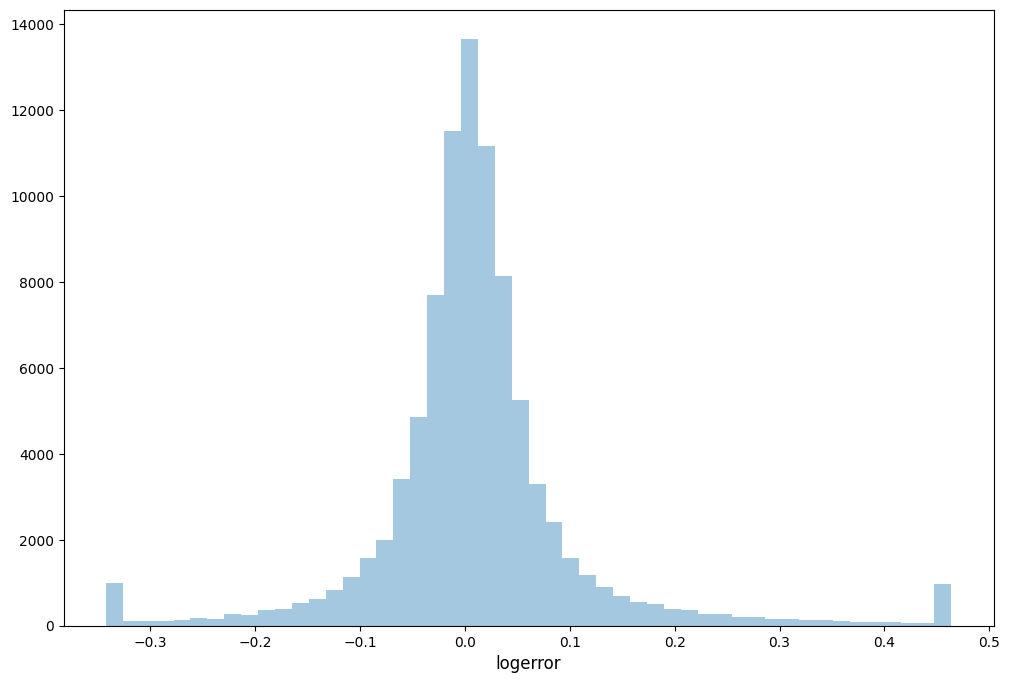

In [11]:
#1분위수와 99분위수 제거후 이상치 탐지
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df.loc[train_df['logerror']>ulimit, 'logerror'] = ulimit
train_df.loc[train_df['logerror']<llimit, 'logerror'] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

좋은 정규분포...? 좀 더 제거해도 괜찮지 않았으려나

###### Transaction Date:

거래 일자. 각 달의 거래 확인

In [12]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

In [13]:
train_df.head()

,parcelid,logerror,transactiondate,transaction_month
0,11016594,0.0276,2016-01-01,1
1,14366692,-0.1684,2016-01-01,1
2,12098116,-0.0040,2016-01-01,1
3,12643413,0.0218,2016-01-02,1
4,14432541,-0.0050,2016-01-02,1


In [14]:
cnt_srs = train_df['transaction_month'].value_counts()

In [16]:
cnt_srs

6     10922
8     10476
5      9961
7      9947
9      9575
4      9311
3      8652
1      6556
2      6333
10     4977
11     1826
12     1739
Name: transaction_month, dtype: int64

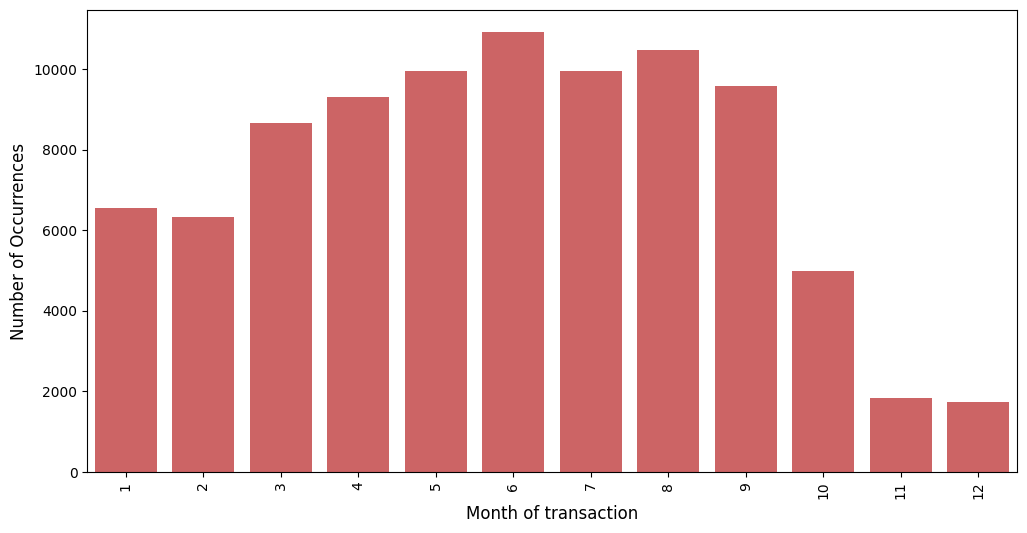

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

데이터 페이지에서 확인할 수 있듯이, 훈련 데이터에는 2016년 10월 15일 이전의 모든 거래 및 일부 2016년 10월 15일 이후의 거래가 포함되어 있습니다. 따라서, 마지막 세 달은 더 짧은 막대를 가지고 있습니다.

In [19]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [20]:
prop_df = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2016.csv")
prop_df.shape

/tmp/ipykernel_34/2352398109.py:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_df = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2016.csv")


(2985217, 58)

In [21]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


결측값 겁나 많음

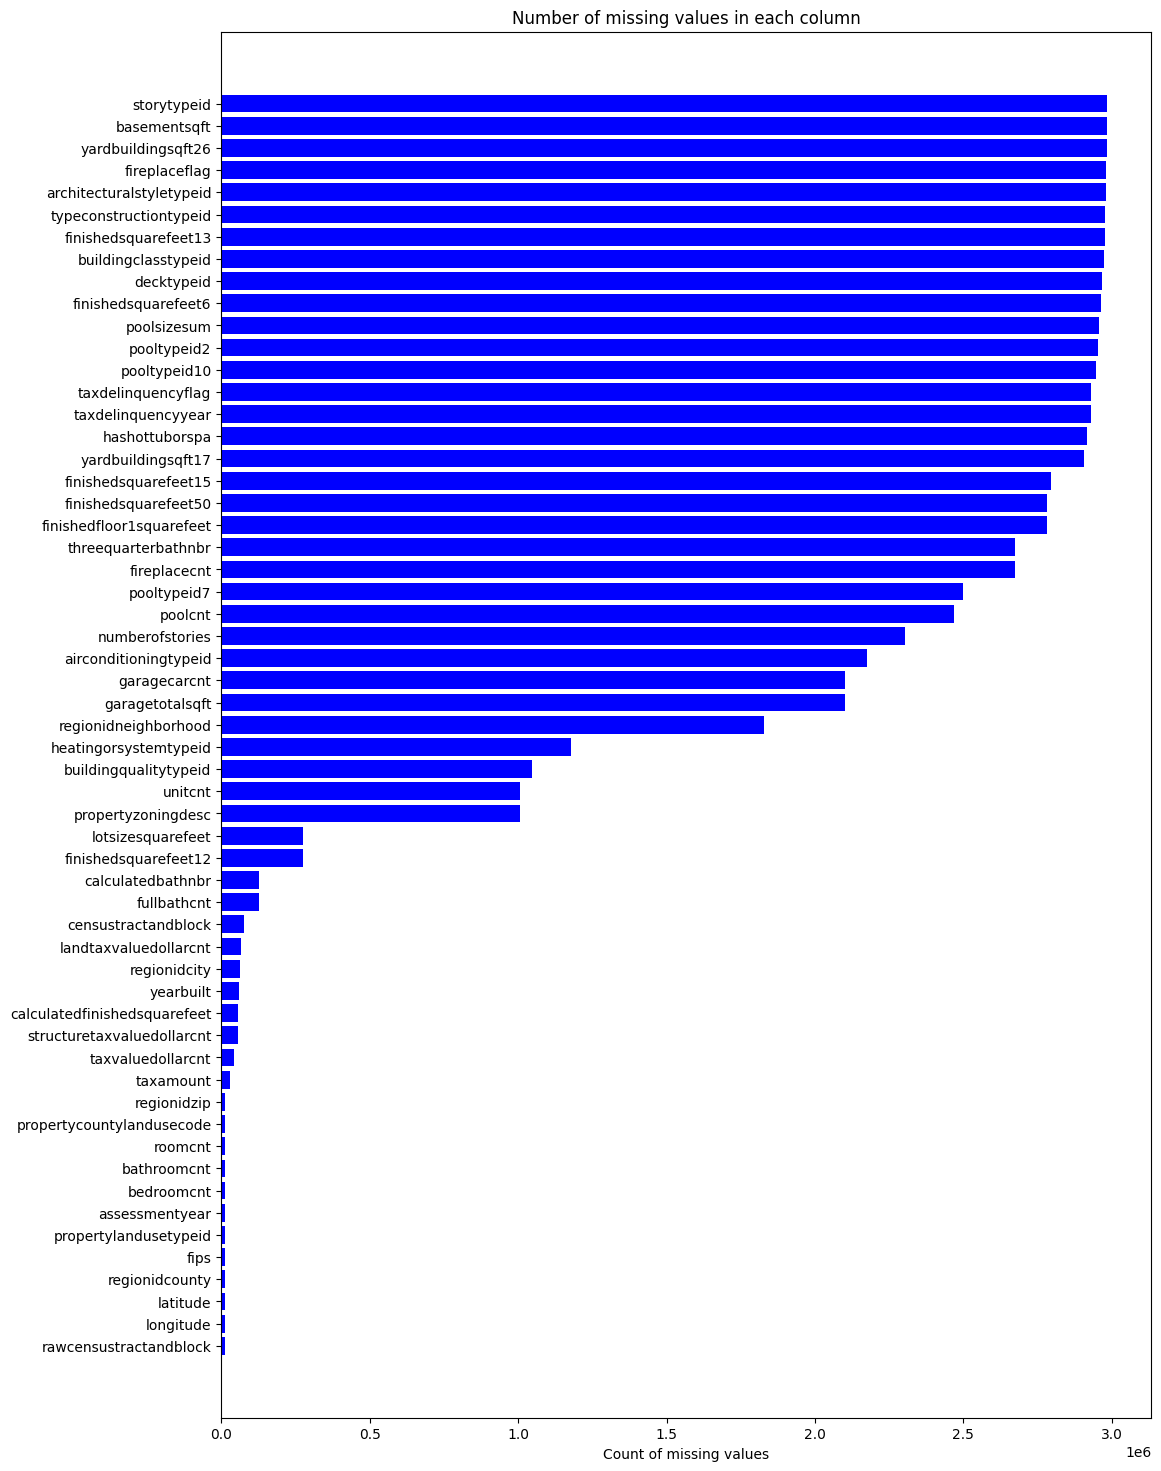

In [23]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

<Figure size 1200x1200 with 0 Axes>

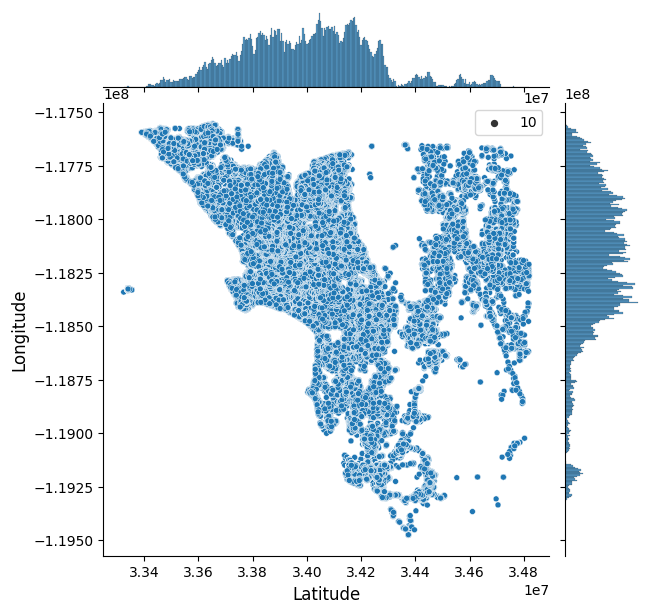

In [24]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

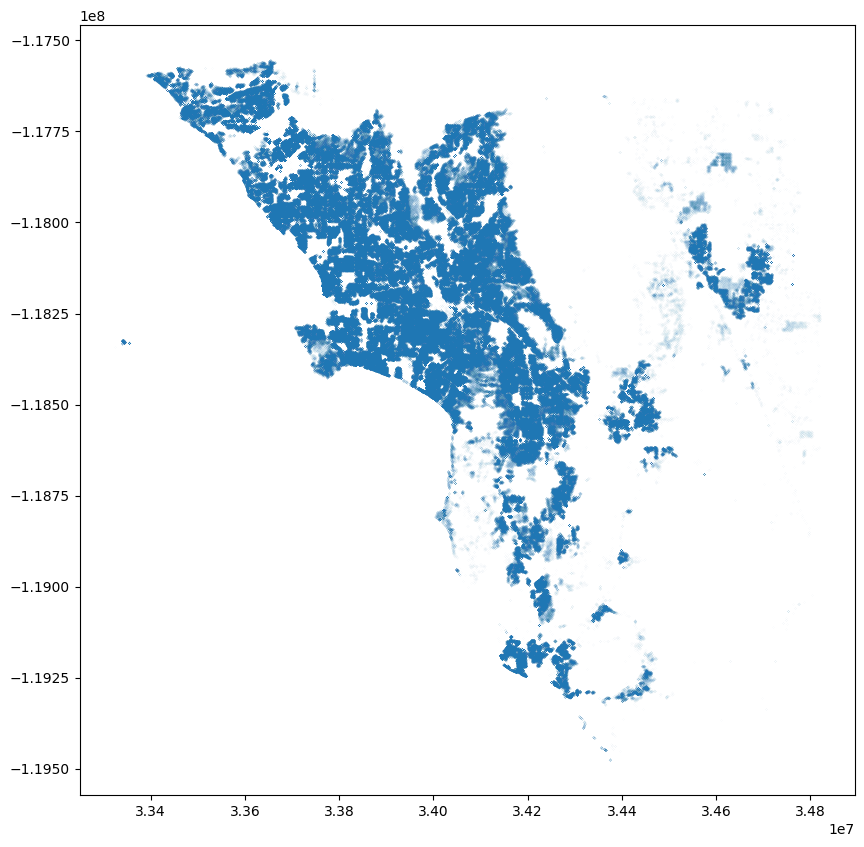

In [27]:
plt.figure(figsize=(10, 10))
plt.plot(prop_df.latitude.values, prop_df.longitude.values, '.', alpha = 0.4, markersize = 0.05)
plt.show()

In [28]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [29]:
#최대 행 개수 수정
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


In [30]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


In [32]:
# 결측값 비율이 99.9% 이상인 컬럼을 필터링하여 출력
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


####  각 열과 'logerror' 열 간의 상관 계수를 계산

/tmp/ipykernel_34/3856897047.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_values = train_df.mean(axis=0)
/tmp/ipykernel_34/3856897047.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_values = train_df.mean(axis=0)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


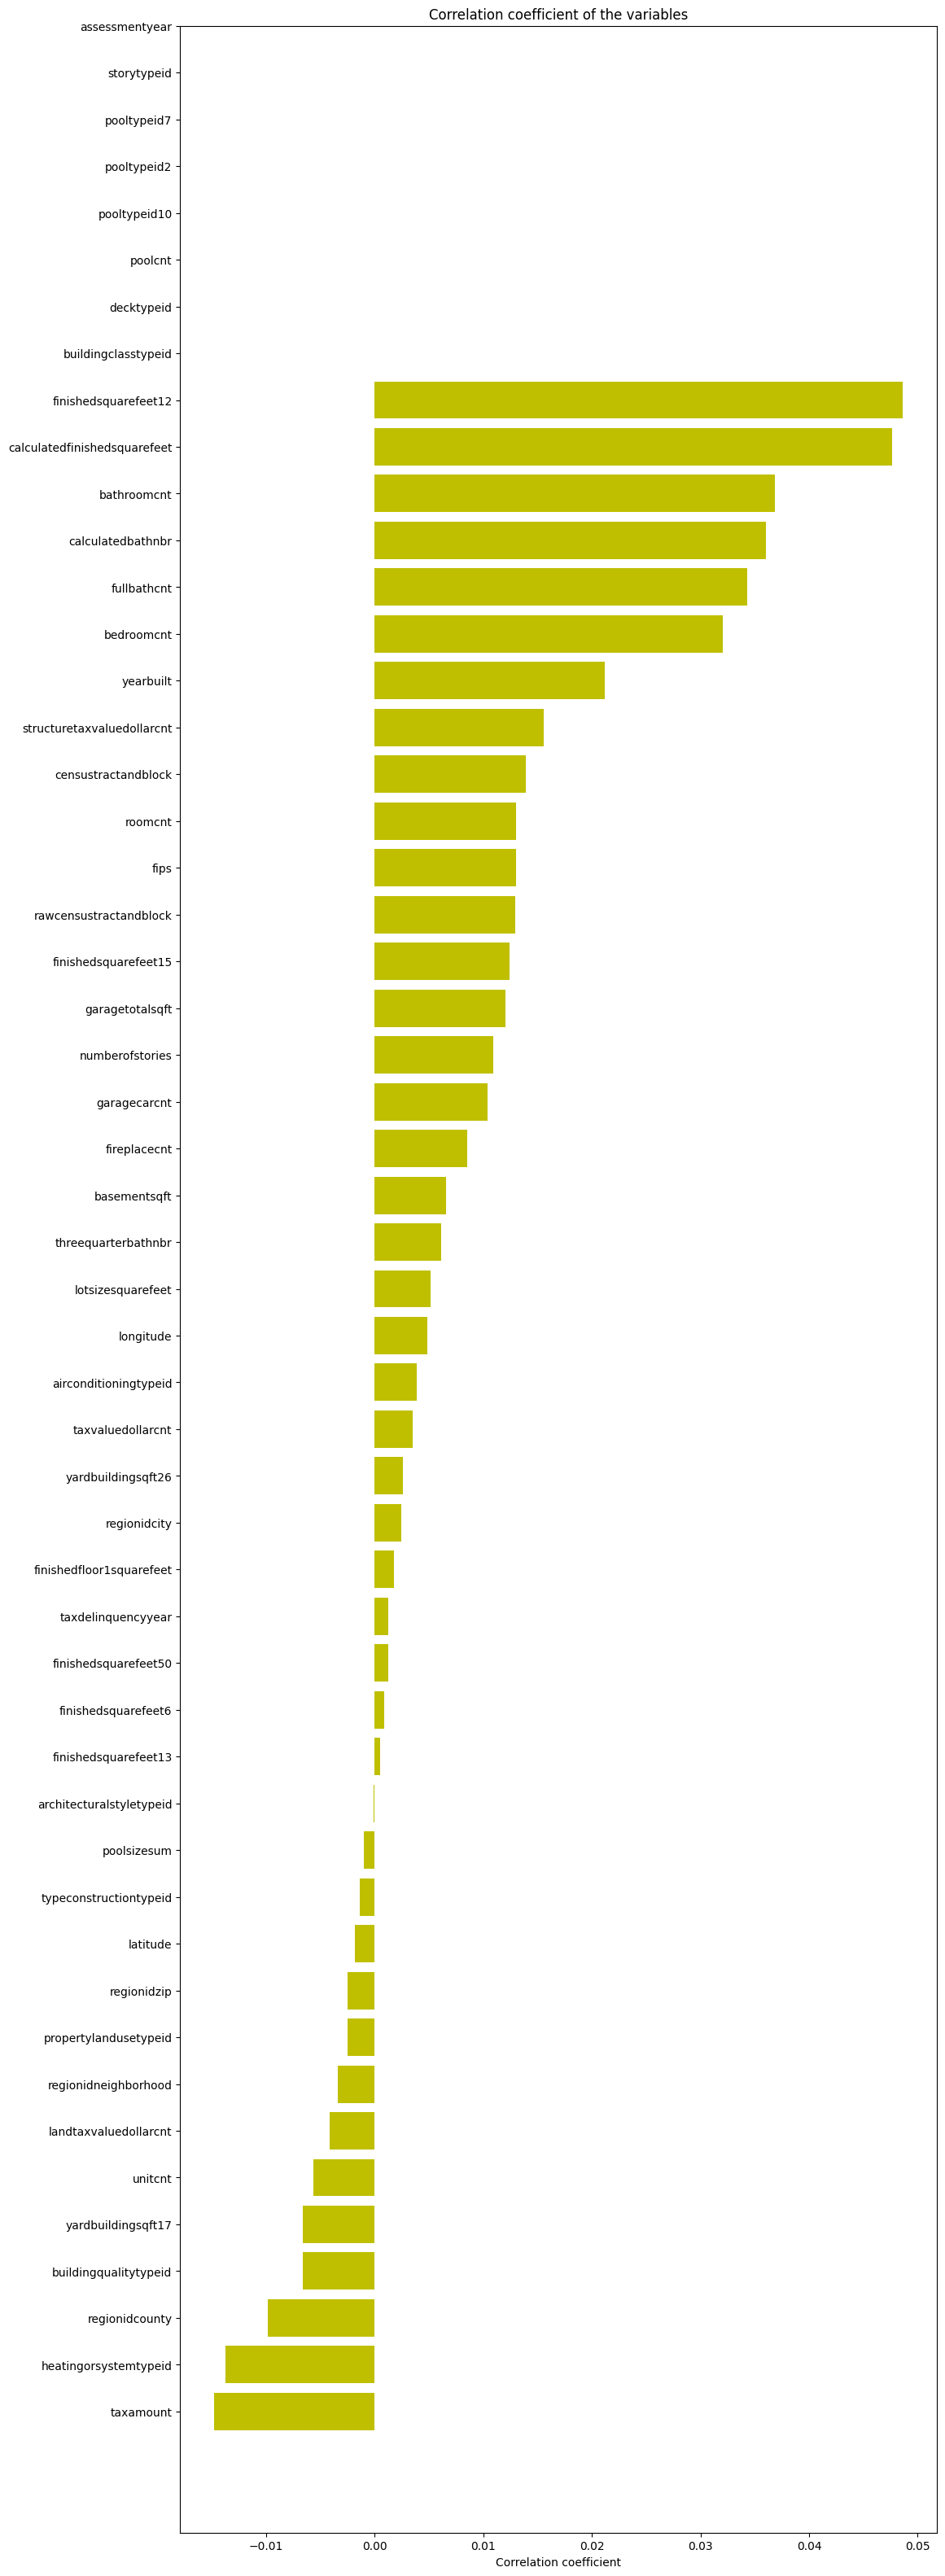

In [34]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()


주어진 변수들과 타겟 변수 간의 상관관계는 전반적으로 낮습니다.

그래프 상단에는 상관관계 값이 없는 몇 가지 변수가 있습니다. 이 변수들은 하나의 고유한 값을 가지고 있기 때문에 상관관계 값이 없다고 추측됩니다. 이를 확인해 보도록 하겠습니다.

In [35]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


In [37]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


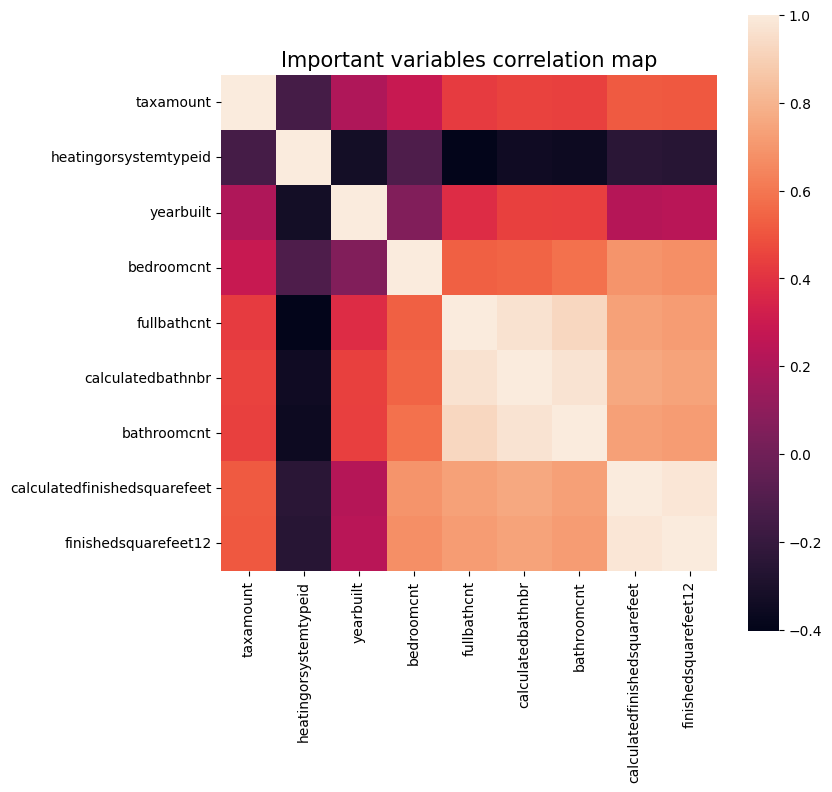

In [38]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

<Figure size 1200x1200 with 0 Axes>

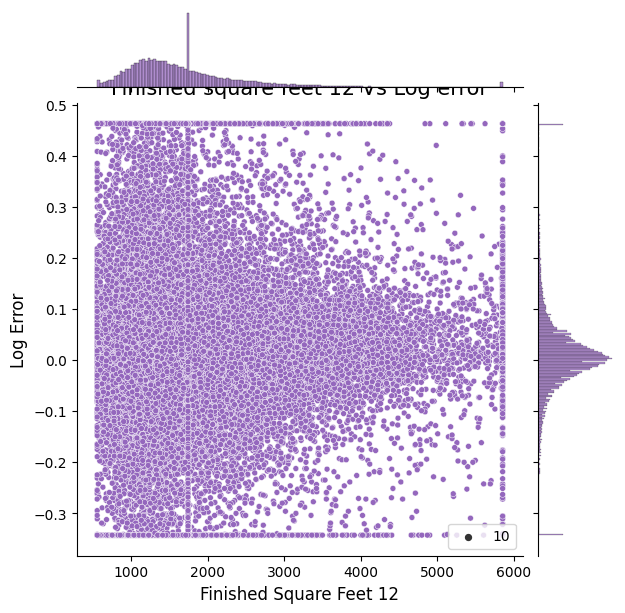

In [40]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

<Figure size 1200x1200 with 0 Axes>

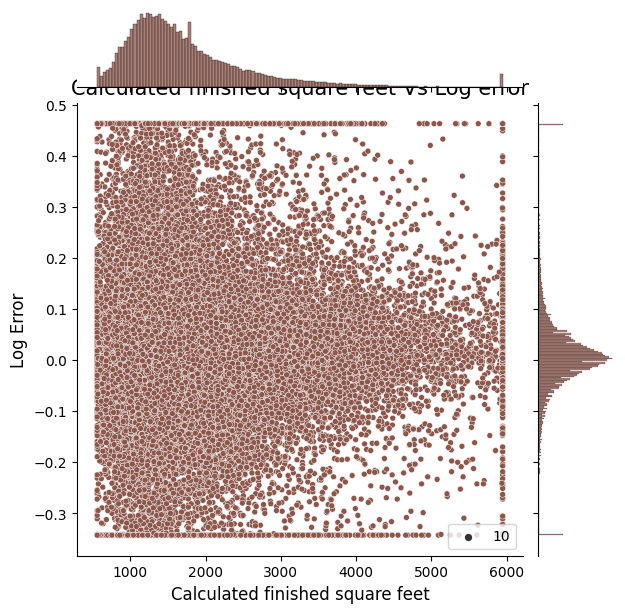

In [42]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

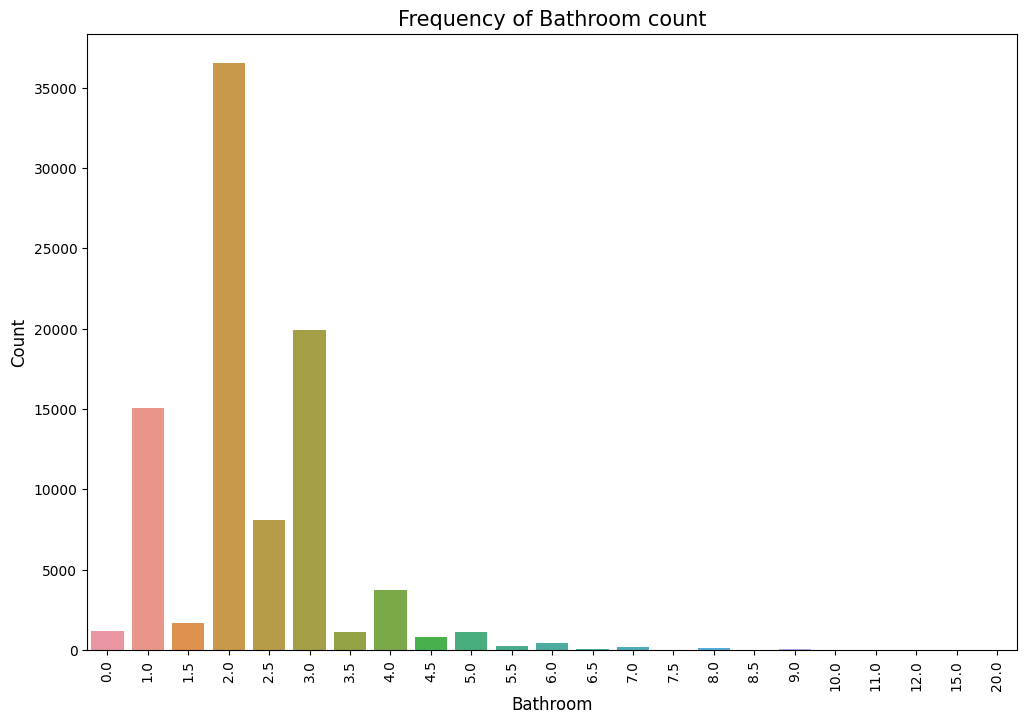

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

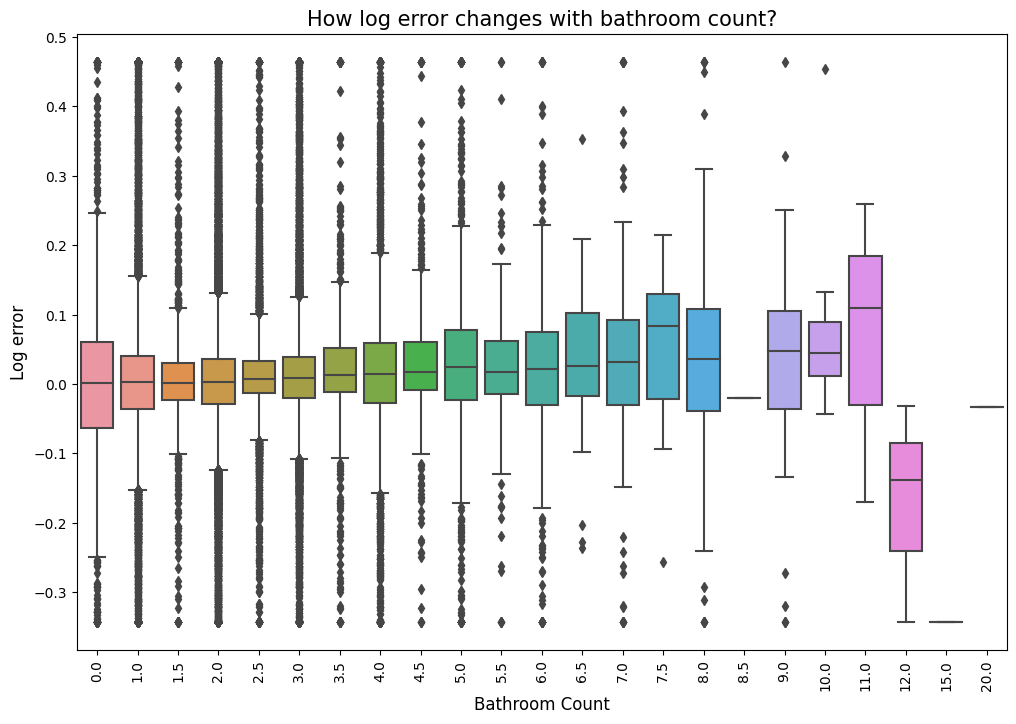

In [44]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

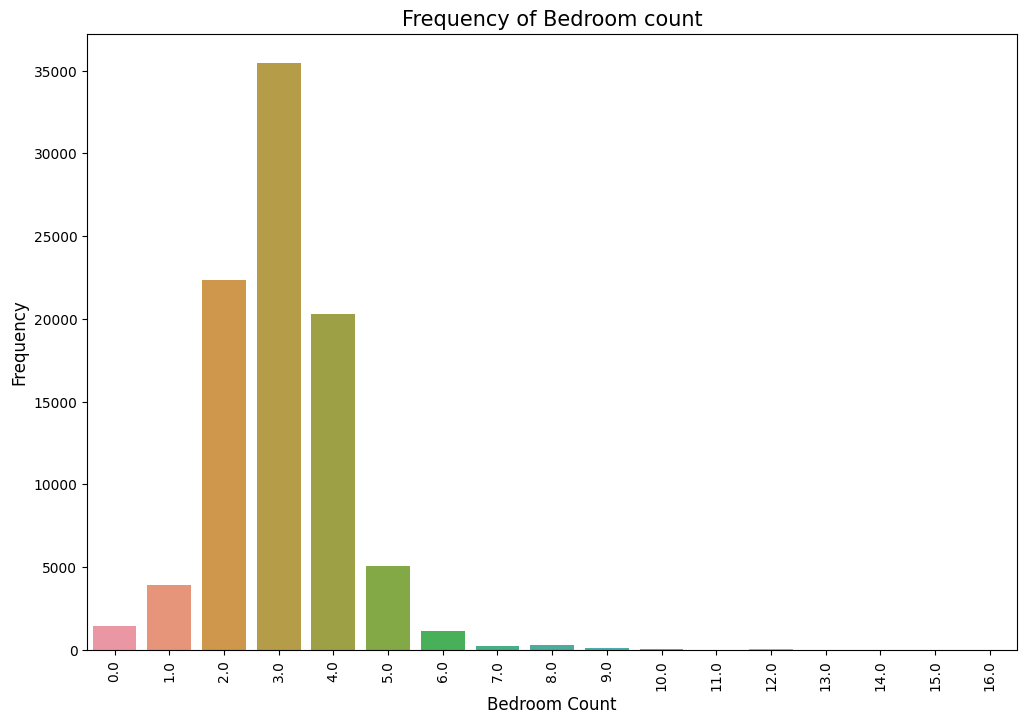

In [45]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

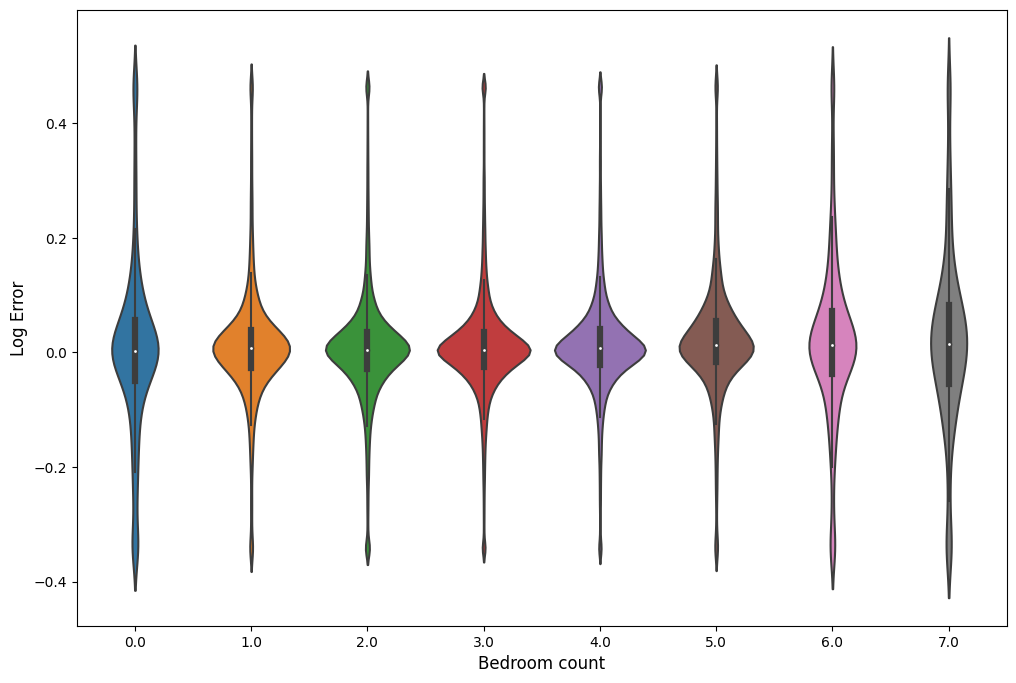

In [47]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

<Figure size 1200x1200 with 0 Axes>

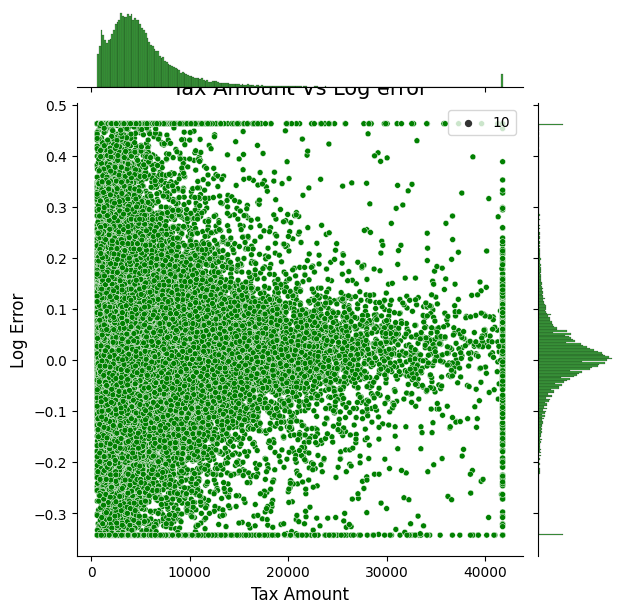

In [49]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

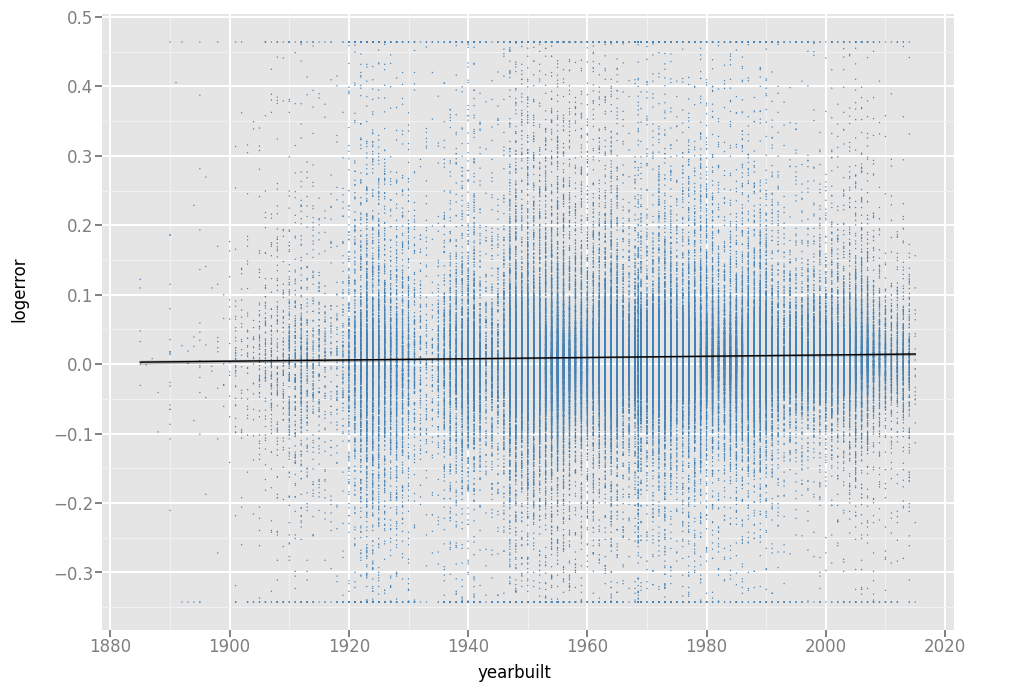

<ggplot: (8672754676499)>

In [50]:
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

In [60]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = mcolors.LinearSegmentedColormap.from_list(name='my_cmap', colors=['red', 'blue'])
cm.register_cmap(name='my_cmap', cmap=cmap)

ValueError: A colormap named "my_cmap" is already registered.

In [70]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list(name='my_cmap', colors=['red', 'blue'])
mcolors.register_cmap(name='my_cmap', cmap=cmap)

ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(cmap='my_cmap', low='pink', high='blue')

AttributeError: module 'matplotlib.colors' has no attribute 'register_cmap'

In [71]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

ValueError: A colormap named "gradient2n" is already registered.

TypeError: unhashable type: 'LinearSegmentedColormap'

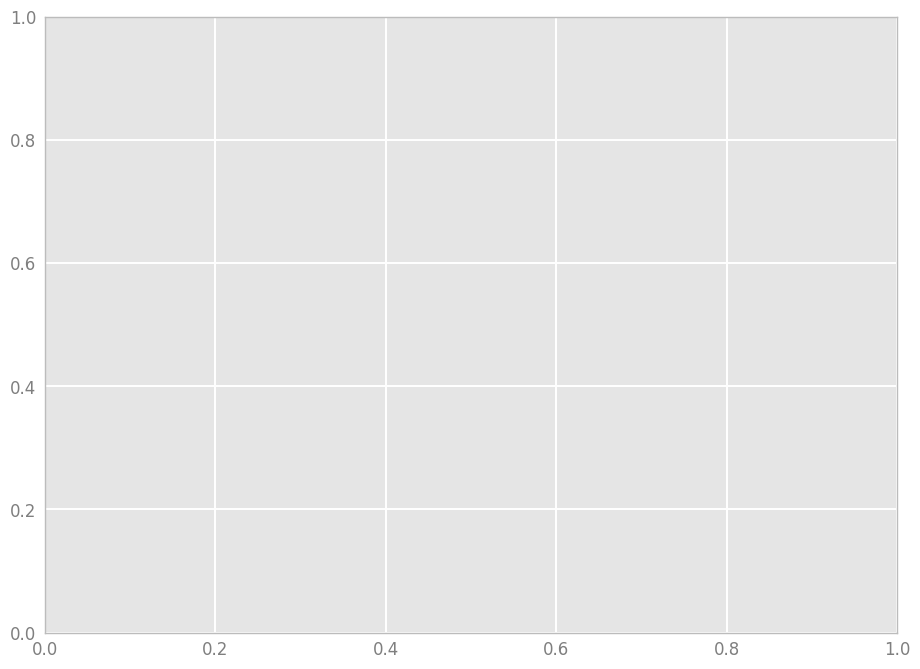

In [72]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_now_its_art()

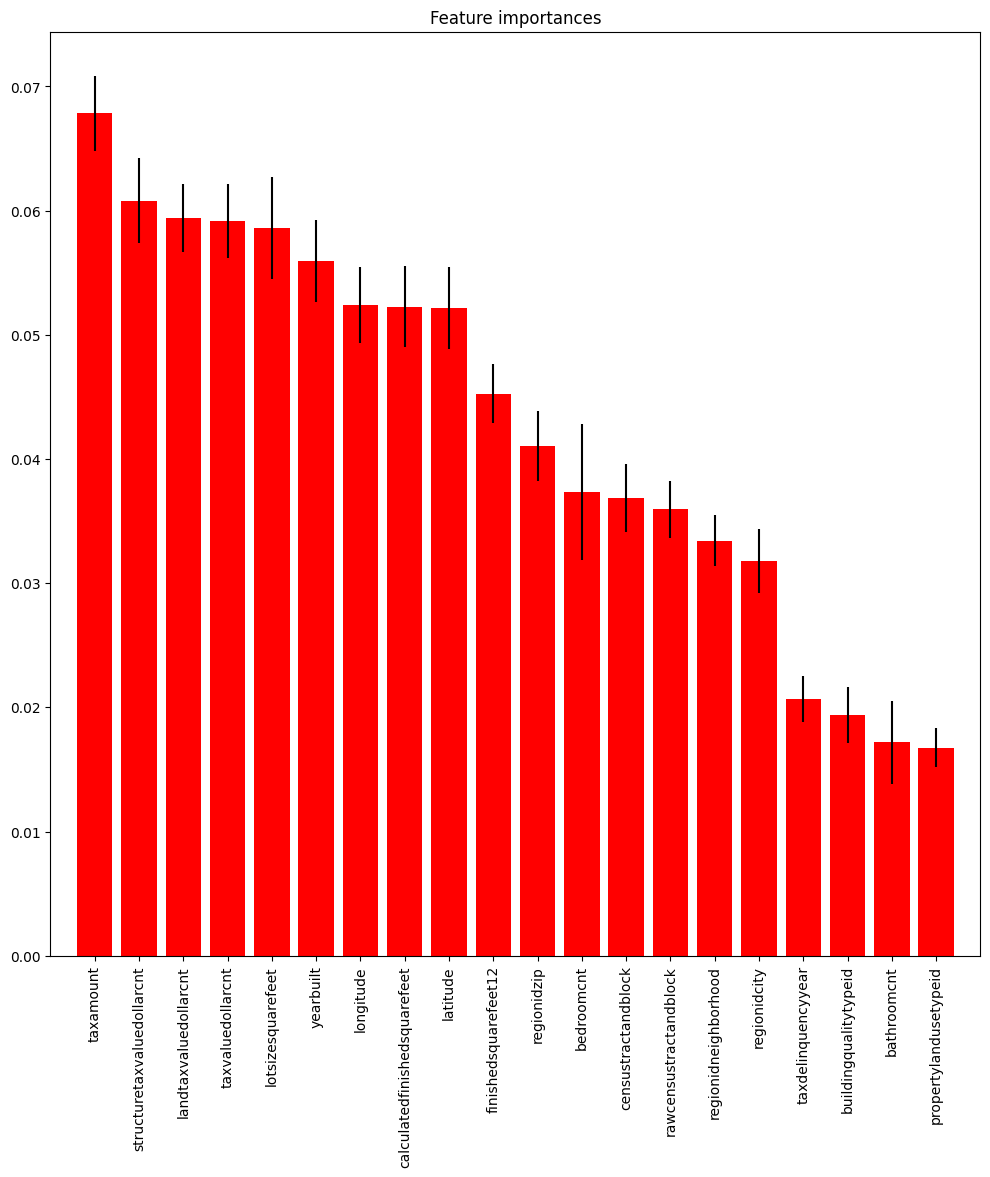

In [73]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

[16:22:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



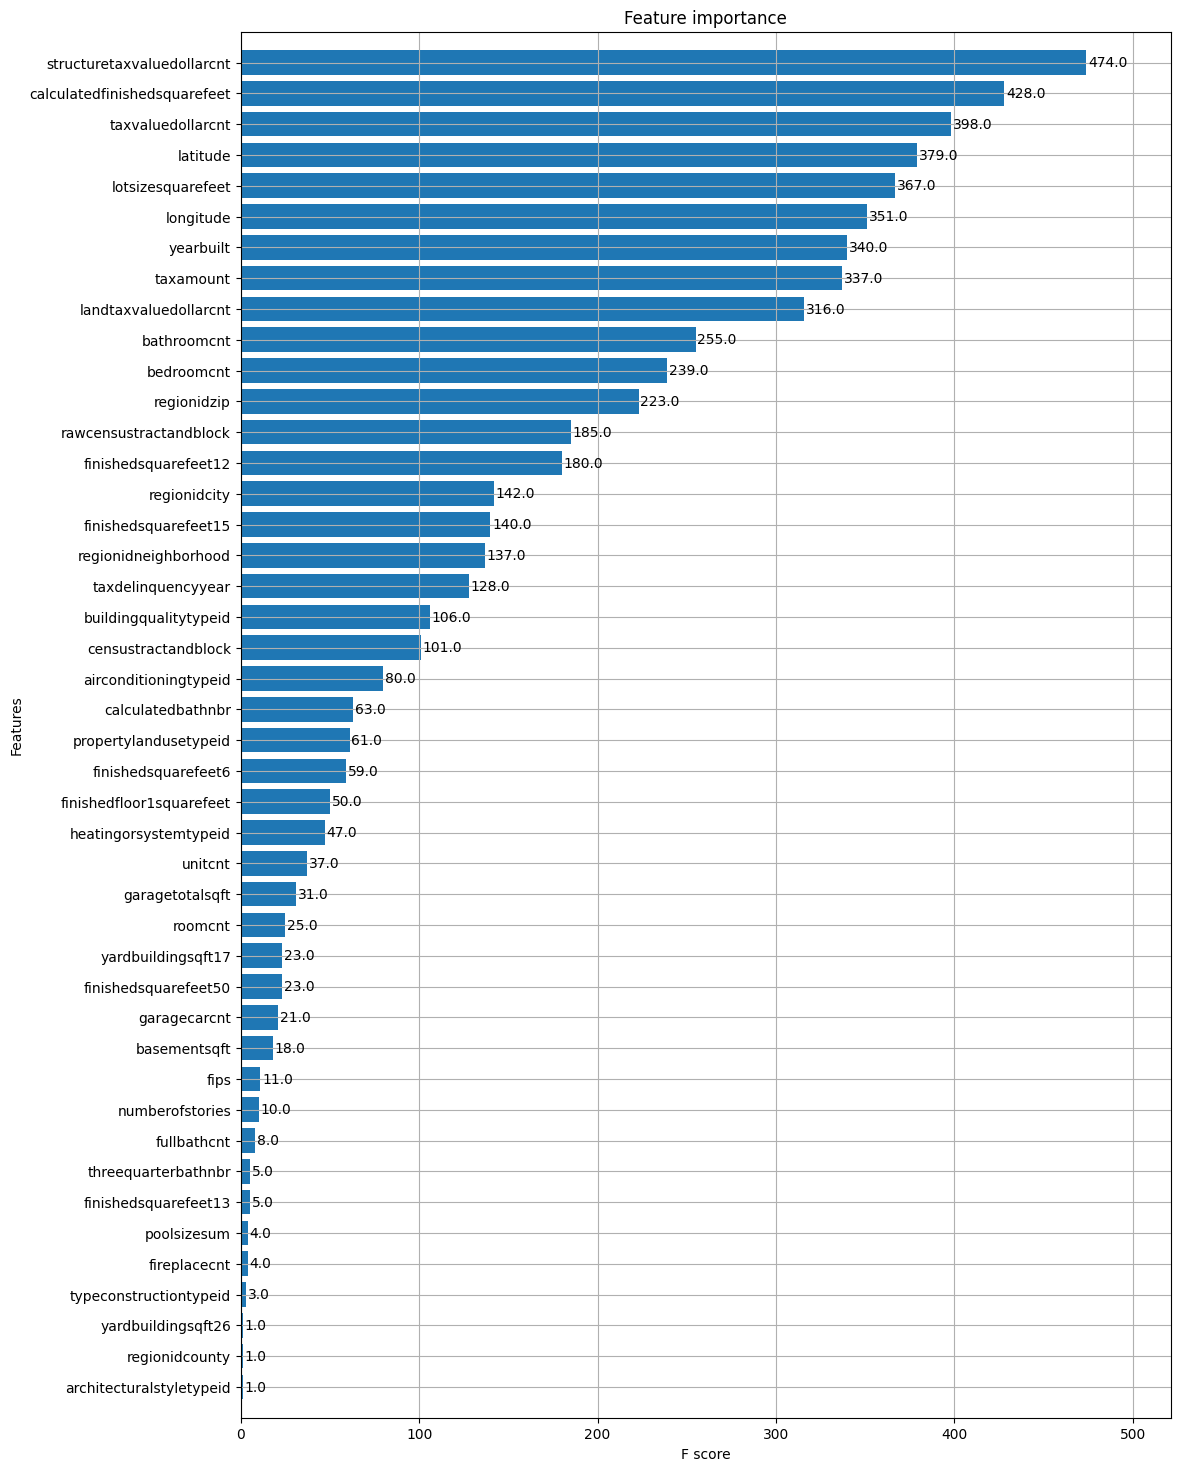

In [74]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()